# Membership Inference Attack (MIA) Dataset C

In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
print('Libraries imported!!')

Libraries imported!!


In [2]:
#define directory of functions and actual directory
HOME_PATH = '' #home path of the project
FUNCTIONS_DIR = 'EVALUATION FUNCTIONS/PRIVACY'
ACTUAL_DIR = os.getcwd()

#change directory to functions directory
os.chdir(HOME_PATH + FUNCTIONS_DIR)

#import functions for membership attack simulation
from membership_inference import evaluate_membership_attack

#change directory to actual directory
os.chdir(ACTUAL_DIR)
print('Functions imported!!')

Functions imported!!


## 1. Read real and synthetic datasets
In this part real and synthetic datasets are read.

In [3]:
#Define global variables
DATA_TYPES = ['Real','GM','SDV','CTGAN','WGANGP']
SYNTHESIZERS = ['GM','SDV','CTGAN','WGANGP']
FILEPATHS = {'Real' : HOME_PATH + 'REAL DATASETS/TRAIN DATASETS/C_Obesity_Data_Real_Train.csv',
            'GM' : HOME_PATH + 'SYNTHETIC DATASETS/GM/C_Obesity_Data_Synthetic_GM.csv',
            'SDV' : HOME_PATH + 'SYNTHETIC DATASETS/SDV/C_Obesity_Data_Synthetic_SDV.csv',
            'CTGAN' : HOME_PATH + 'SYNTHETIC DATASETS/CTGAN/C_Obesity_Data_Synthetic_CTGAN.csv',
            'WGANGP' : HOME_PATH + 'SYNTHETIC DATASETS/WGANGP/C_Obesity_Data_Synthetic_WGANGP.csv'}
categorical_columns = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS','Obesity_level']
data = dict()
Q=5

In [4]:
#iterate over all datasets filepaths and read each dataset
data = dict()

for name, path in FILEPATHS.items() :
    data[name] = pd.read_csv(path)
    for col in categorical_columns :
        data[name][col] = data[name][col].astype('category').cat.codes
    numerical_columns = data[name].select_dtypes(include=['int64','float64']).columns.tolist()
    for col in numerical_columns :
        data[name][col] = pd.qcut(data[name][col], q=Q, duplicates='drop').cat.codes
data

{'Real':       Gender  Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
 0          0    1       1       0                               1     1     3   
 1          0    1       3       4                               1     1     3   
 2          0    2       1       2                               1     1     0   
 3          0    2       0       0                               0     0     3   
 4          1    3       4       3                               1     1     3   
 ...      ...  ...     ...     ...                             ...   ...   ...   
 1683       1    4       3       4                               1     1     3   
 1684       1    2       2       2                               1     1     0   
 1685       0    2       1       2                               1     1     0   
 1686       0    2       1       2                               1     1     2   
 1687       1    1       4       2                               1     1     3   
 
      

In [5]:
#read TRAIN real dataset
train_data = pd.read_csv(HOME_PATH + 'REAL DATASETS/TRAIN DATASETS/C_Obesity_Data_Real_Train.csv')
for col in categorical_columns :
    train_data[col] = train_data[col].astype('category').cat.codes
for col in numerical_columns :
    train_data[col] = pd.qcut(train_data[col], q=Q, duplicates='drop').cat.codes
train_data = train_data.sample(frac=1)
    
#read TEST real dataset
test_data = pd.read_csv(HOME_PATH + 'REAL DATASETS/TEST DATASETS/C_Obesity_Data_Real_Test.csv')
for col in categorical_columns :
    test_data[col] = test_data[col].astype('category').cat.codes
for col in numerical_columns :
    test_data[col] = pd.qcut(test_data[col], q=Q, duplicates='drop').cat.codes
print(len(test_data))
test_data.index = range(len(train_data), len(train_data) + len(test_data))

real_data = (pd.concat([train_data[0:len(test_data)], test_data])).sample(frac=1)
real_data

423


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity_level
809,1,2,4,4,1,1,2,1,2,0,3,0,4,1,2,3,3
1980,1,0,3,0,0,1,0,1,2,0,1,0,3,0,1,1,1
1994,1,2,4,2,1,1,0,0,2,0,1,0,0,3,1,3,6
305,1,1,1,2,1,0,0,1,2,0,1,0,2,3,3,4,6
1839,1,2,2,0,1,1,2,2,1,0,0,0,0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,0,3,0,1,1,1,2,0,2,0,1,0,0,0,2,0,2
1881,1,0,3,1,1,1,0,2,1,0,1,0,3,2,1,0,1
1,0,1,3,4,1,1,3,1,2,0,4,0,3,1,2,3,4
1953,0,3,0,3,1,1,2,1,2,0,0,0,0,1,1,3,4


In [6]:
thresholds = [0.4, 0.3, 0.2, 0.1]
props = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

train_data_indexes = train_data.index.tolist()
precision_values_all = dict()
accuracy_values_all = dict()

for name in SYNTHESIZERS :
    print(name)
    precision_values = dict()
    accuracy_values = dict()
    
    for th in thresholds :
        precision_values[th] = []
        accuracy_values[th] = []
        
        for p in props :
            
            attacker_data = real_data.iloc[0:int(len(real_data)*p)]
            precision_vals, accuracy_vals = evaluate_membership_attack(attacker_data, train_data_indexes, data[name], th)
            
            precision_values[th].append(precision_vals)
            accuracy_values[th].append(accuracy_vals)
            
            print('Proportion ', p, ' Threshold ', th, ' analysed')
            print('- mean precision', np.mean(precision_values[th]))
            print('- mean accuracy', np.mean(accuracy_values[th]))
    print('###################################################')
    
    precision_values_all[name] = precision_values
    accuracy_values_all[name] = accuracy_values

GM
Proportion  0.2  Threshold  0.4  analysed
- mean precision 0.5297619047619048
- mean accuracy 0.5325443786982249
Proportion  0.3  Threshold  0.4  analysed
- mean precision 0.5446428571428572
- mean accuracy 0.5469046004163061
Proportion  0.4  Threshold  0.4  analysed
- mean precision 0.5466269841269842
- mean accuracy 0.5480350196069259
Proportion  0.5  Threshold  0.4  analysed
- mean precision 0.5442184481191045
- mean accuracy 0.5445960046579131
Proportion  0.6  Threshold  0.4  analysed
- mean precision 0.540344937421725
- mean accuracy 0.5402132928782043
Proportion  0.7  Threshold  0.4  analysed
- mean precision 0.5375890351530247
- mean accuracy 0.5371709873084135
Proportion  0.8  Threshold  0.4  analysed
- mean precision 0.5339198532604158
- mean accuracy 0.5333401362051828
Proportion  0.9  Threshold  0.4  analysed
- mean precision 0.5299275598459285
- mean accuracy 0.5292547479574587
Proportion  1  Threshold  0.4  analysed
- mean precision 0.5264703144790412
- mean accuracy 0.

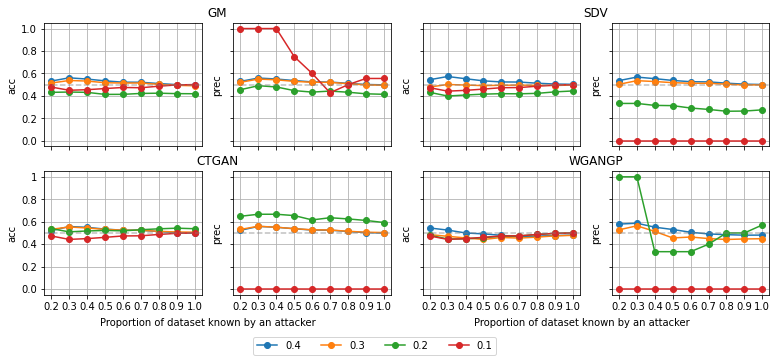

In [7]:
colors = ['tab:blue','tab:orange','tab:green','tab:red']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(13,2.5*2))
idx = {SYNTHESIZERS[0] : {'accuracy' : [0,0], 'precision' : [0,1]},
       SYNTHESIZERS[1] : {'accuracy' : [0,2], 'precision' : [0,3]},
       SYNTHESIZERS[2] : {'accuracy' : [1,0], 'precision' : [1,1]},
       SYNTHESIZERS[3] : {'accuracy' : [1,2], 'precision' : [1,3]}}
first = True
for name in SYNTHESIZERS :
    ax_pre = axs[idx[name]['precision'][0], idx[name]['precision'][1]]
    ax_acc = axs[idx[name]['accuracy'][0], idx[name]['accuracy'][1]]
    precision_values = precision_values_all[name]
    accuracy_values = accuracy_values_all[name]
    
    for i in range(0,len(thresholds)) :
        ax_pre.plot(props, precision_values[thresholds[i]], 'o-', color=colors[i])
        ax_acc.plot(props, accuracy_values[thresholds[i]], 'o-', color=colors[i])
    
    ax_pre.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax_acc.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax_pre.set_ylabel('prec')
    ax_acc.set_title(name, fontsize=12)
    ax_acc.title.set_position([1.1, 1.03])
    ax_pre.set_ylim(-0.05,1.05)
    ax_acc.set_ylabel('acc')
    ax_acc.set_ylim(-0.05,1.05)
    ax_acc.grid(True)
    ax_pre.grid(True)
    ax_acc.set_yticks([0.0,0.2,0.4,0.6,0.8,1])
    ax_pre.set_yticks([0.0,0.2,0.4,0.6,0.8,1])
    ax_acc.set_xticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax_pre.set_xticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    
    if first == False :
        ax_acc.set_yticklabels([])
    else :
        first = False
        
    ax_pre.set_yticklabels([])
    ax_acc.set_xticklabels([])
    ax_pre.set_xticklabels([])
        

axs[idx['CTGAN']['accuracy'][0],idx['CTGAN']['accuracy'][1]].set_yticklabels([0.0,0.2,0.4,0.6,0.8,1])   
axs[idx['CTGAN']['accuracy'][0],idx['CTGAN']['accuracy'][1]].set_xticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])  
axs[idx['CTGAN']['precision'][0],idx['CTGAN']['precision'][1]].set_xticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs[idx['WGANGP']['accuracy'][0],idx['WGANGP']['accuracy'][1]].set_xticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs[idx['WGANGP']['precision'][0],idx['WGANGP']['precision'][1]].set_xticklabels([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
fig.text(0.7, 0.04, 'Proportion of dataset known by an attacker', ha='center')
fig.text(0.3, 0.04, 'Proportion of dataset known by an attacker', ha='center')
ax_pre.legend(thresholds, ncol=len(thresholds), bbox_to_anchor=(-0.7, -0.3))
fig.tight_layout()
#fig.suptitle('Membership Inference Tests Results \n Dataset F - Indian Liver Patient', fontsize=18)
fig.savefig('INFERENCE TESTS RESULTS/MEMBERSHIP INFERENCE TESTS RESULTS.svg', bbox_inches='tight')